In [1]:
#basic imports and ipython setup
import matplotlib.pyplot as plt
import numpy as np

from abc import ABC

import os.path

from MCEq.core import MCEqRun
import mceq_config as config
import crflux.models as pm

from tqdm import tqdm

from scipy.sparse import find

import pandas as pd
from MCEq.geometry.density_profiles import GeneralizedTarget

import matplotlib as mpl
from cycler import cycler
from astropy.io import fits

import daemonflux

In [2]:
hdus = fits.open('balco_14co_const_models.fits')

In [3]:
hdus['FOFACTOR'].data[68]

(0.066, 0.072)

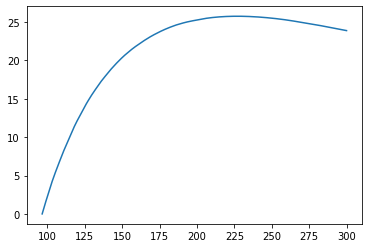

In [4]:
plt.plot(hdus['DEPTH'].data, hdus['CO14'].data[68])

## Setup Grid Parameters

In [5]:
age_scale_file = 'DomeC_age_scale_Apr2023.csv' # relationship between age and depth of ice at Dome-C
ice_eq_depth_file = 'Real_vs_ice_eq_depth.csv' # relationship bewteen ice-equivalent-depth and real-depth at Dome-C

# read age-scale file
age_scale = pd.read_csv(age_scale_file)
ages = np.array(age_scale['ages']) # years
depths_real = np.array(age_scale['depths_real']) # meters

# read ice-eq-depth file
ice_eq_depth = pd.read_csv(ice_eq_depth_file)
real_z = ice_eq_depth['z'] # meters
ice_eq_z = ice_eq_depth['ice_eq_z'] # meters (ice-eq) aka mass-depth / ice density

In [6]:
rho_ice = 0.9239 # density of solid ice at Dome C (g/cm^3)

def z_to_t(z): # convert real depth to age
    return np.interp(z, depths_real, ages)

def t_to_z(t): # convert age to real depth
    return np.interp(t, ages, depths_real)

def z_to_h(z): # convert real depth to mass depth
    return np.interp(z, real_z, ice_eq_z)*rho_ice

def h_to_z(h): # convert mass depth to real depth
    return np.interp(h/rho_ice, ice_eq_z, real_z)

def h_to_t(h): # convert mass depth to age
    return z_to_t(h_to_z(h/rho_ice))

def t_to_h(t): # convert age to mass depth
    return z_to_h(t_to_z(t))*rho_ice

In [7]:
def argnear_below(x, a): #assuming sorted low -> high
    return max(min(int(np.interp(x, a, np.arange(len(a)))), len(a)-1), 0)

def argnear_above(x, a): #assuming sorted low -> high
    return max(min(int(np.interp(x, a, np.arange(len(a))))+1, len(a)-1), 0)

## Depth

In [8]:
z_min = 0 # starting depth for plots (m)
z_deep = 300 # end depth (m)

i_min = argnear_below(z_min, depths_real) # nearest depths_real index to z_min
i_end = argnear_above(z_deep, depths_real) # nearest depths_real index to z_end

In [9]:
# Define depth bins
z_bins = depths_real[i_min:i_end+1] # depth bin edges in steps of 1-year ice age (m)
z = (z_bins[:-1]+z_bins[1:])/2 # bin-average of z (m)
dz = np.diff(z_bins) # bin-width of z (m)

# Define mass depth bins
h_bins = z_to_h(z_bins) # mass depth bin edges corresponding to z bins (m.w.e = hg/cm^2)
h = (h_bins[:-1]+h_bins[1:])/2 # bin-average of h (m.w.e = hg/cm^2)
dh = np.diff(h_bins) # bin-width of h (m.w.e = hg/cm^2)

rho = dh/dz # density of depth bins

# Define time bins
t_bins = z_to_t(z_bins) # ice age bins corresponding to z array (years)
t = (t_bins[:-1]+t_bins[1:])/2 # bin-average of t (years)
dt = np.diff(t_bins) # bin-width of t (years)

## Sample Range

In [10]:
z_start = 96.5 # starting depth of 14C accumulation (m) - close-off depth beneath firn layer
sample_length = 20 # length of ice core samples (m)

i_start = argnear_below(z_start, z_bins) # index of first bin beneath starting point for 14C accumulation

z_samp_ideal = np.arange(z_bins[i_start],z_bins[-1],sample_length)
i_samp = np.append(np.argmin(abs(z_bins.reshape((1,-1))-z_samp_ideal.reshape(-1,1)), axis=1), len(z_bins)-1)
i_samp[0] = i_start # just making sure

# Define sample depth bins
z_samp_bins = z_bins[i_samp] # sample depth bin edges (m)
z_samp = (z_samp_bins[:-1]+z_samp_bins[1:])/2 # bin-average of sample depth (m)
dz_samp = np.diff(z_samp_bins) # bin-width of sample depth (m)

# Define sample compression matrix
dh_samp = np.zeros(len(i_samp)-1)
S_mat = np.zeros((len(z_bins)-1, len(i_samp)-1))
for i in range(len(i_samp)-1):
    dh_samp[i] = np.sum(dh[i_samp[i]:i_samp[i+1]])
    S_mat[i_samp[i]:i_samp[i+1], i] = dh[i_samp[i]:i_samp[i+1]]/dh_samp[i]

In [11]:
i_int = np.arange(i_start,len(z))

## Zenith Angle

In [12]:
N_ang = 10

# Define zenith angle bins
cosTH_bins = np.linspace(1,0,N_ang+1)
cosTH = (cosTH_bins[:-1]+cosTH_bins[1:])/2
dcosTH = -np.diff(cosTH_bins)

## Energy

In [13]:
logE_min = -1 # minimum energy (log10 GeV)
logE_max = 11 # maximum energy (log10 GeV)
dlogE = 0.1 # energy bin width (log10 GeV)

# Define energy bins
logE_bins = np.arange(logE_min, logE_max+dlogE, dlogE) # log10 GeV
logE = (logE_bins[:-1]+logE_bins[1:])/2 # log10 GeV
E_bins = 10.**(logE_bins) # GeV
E = 10.**(logE) # bin-average of E (GeV)
dE = np.diff(E_bins) # bin-width of E (GeV)

# how to average E?  Currently doing geometric mean, but maybe there's a better way.

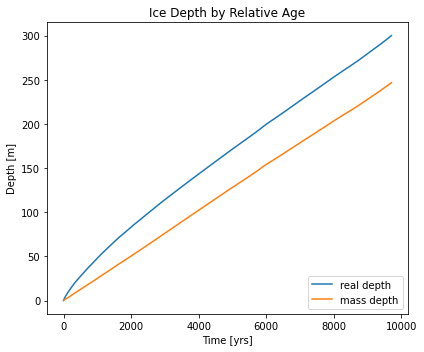

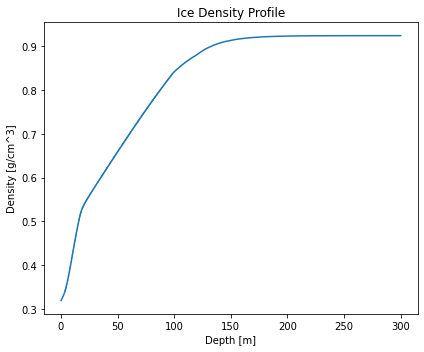

In [14]:
# Plot depth, mass depth, and time
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(t, z, label='real depth')
ax.plot(t, h, label='mass depth')
ax.set(xlabel='Time [yrs]',
       ylabel='Depth [m]')
ax.legend(loc='lower right', fontsize=10)
plt.title('Ice Depth by Relative Age')
plt.show()

# Plot density
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(z, rho)
ax.set(xlabel='Depth [m]',
       ylabel='Density [g/cm^3]')
#ax.legend(loc='lower right', fontsize=10)
plt.title('Ice Density Profile')
plt.show()

## Atmospheric Muon Fits

In [15]:
def judge_nash(E0, cosTH):
    H_pi = 114 #GeV
    H_K = 851 #GeV
    gamma_pi = 2.7
    gamma_K = gamma_pi
    A_pi = 0.28
    A_K = 0.0455
    y0 = 1000 # Atmosphere depth at sea level? (g/cm^2)
    r_pi = 0.76 #muon to parent pion energy ratio
    r_K = 0.523 #muon to parent kaon energy ratio
    q = 2.2e-3 #mean energy loss of the muon in the atmosphere (GeV cm^2/g)
    tau_mu = 2.2e-6 #mean muon lifetime (s)
    tau_pi = 2.61e-8 #mean pion lifetime (s)
    tau_K = 1.24e-8 #mean kaon lifetime (s)
    g = 981.3 #acceleration due to gravity (cm/s^2)
    R = 8.314e7 #gas constant (g cm^2/s^2 /K /mol)
    m_mu = 105.659e-3 #muon rest mass (GeV/c^2)
    m_pi = 139.580e-3 #pion rest mass (GeV/c^2)
    m_K = 493.800e-3 #kaon rest mass (GeV/c^2)
    c = 3e10 #speed of light (cm/s)
    M = 28.966 #effective molecular weight of air (g/mol)
    
    #effective mean temperature of the atmosphere as experienced at zenith angle theta
    T_e = 220 #220 #from Chatzidakis 2015
    
    H_mu = R*m_mu*T_e / c / M / g / tau_mu
    
    E_pi = (E0 + q*y0*(1/cosTH - 0.0874))/r_pi
    
    #H_pi = R*m_pi*c*T_e / M/g/tau_pi
    
    W_pi = (0.0874 * cosTH * (1- q * (y0/cosTH - 90)/r_pi/E_pi))**(H_mu/cosTH/(r_pi*E_pi+90*q))
    
    E_K = (E0 + q*y0*(1/cosTH - 0.0874))/r_K
    
    #H_K = R*m_K*c*T_e / M / g /tau_K
    
    W_K = (0.0874 * cosTH * (1- q * (y0/cosTH - 0.0874)/r_K/E_K))**(H_mu/cosTH/(r_K*E_K+90*q))
    
    Phi_J = A_pi*W_pi*E_pi**(-gamma_pi)*H_pi / (E_pi*cosTH + H_pi) + A_K*W_K*E_K**(-gamma_K)*H_K / (E_K*cosTH + H_K)
    
    return np.nan_to_num(Phi_J)

In [16]:
def bugaev_reyna(E0, cosTH):
    A_B = 0.00253
    a0 = 0.2455
    a1 = 1.288
    a2 = -0.2555
    a3 = 0.0209
    
    y = np.log10(E0*cosTH)
    
    Phi_R = cosTH**3 * A_B * (E0*cosTH)**(-(a3*y**3 + a2*y**2 + a1*y + a0))
    
    return Phi_R

In [17]:
def SDC(E0, cosTH):
    # Smith & Duller / Chatzidakis
    
    A = 0.002382 # fitting parameter
    r = 0.76 # Ratio of muon energy to pion energy
    a = 2.500e-3 # Muon rate of energy loss in air (GeV / (g/cm^2))
    y0 = 1000 # Atmosphere depth at sea level (g/cm^2)
    gamma = 8/3 # fitting parameter
    b_mu = 0.800 # Correction factor related to atmospheric temperature
    m_mu = 105.659e-3 # Rest mass of muon (GeV/c^2)
    tau_mu0 = 2.2e-6 # Mean lifetime of muon at rest (s)
    rho0 = 0.00123 # Density of atmosphere at sea level (g/cm^3)
    c = 3e10 # speed of light (cm/s)
    lambda_pi = 120 # Absorption mean free path of pions (g/cm^2)
    b = 0.771 # coefficient to modify the isothermal atmosphere approximation
    tau0 = 2.61e-8 # Mean lifetime of pion at rest (s)
    m_pi = 139.580e-3 # Rest mass of pion (GeV/c^2)
    j_pi = 148.16 # m_pi * y0 * c / (tau0 * rho0) GeV
    
    # energy of pion that produced muon
    E_pi = (E0 + a*y0*(1/cosTH - 0.100))/r
    
    B_mu = b_mu * m_mu * y0 / (c * tau_mu0 * rho0)
    
    # Probability for muons to reach sea level
    P_mu = (0.100 * cosTH * (1-a*(y0/cosTH - 100)/(r * E_pi)))**(B_mu / ((r*E_pi + 100*a)*cosTH))
    
    Phi_S = A * E_pi**(-gamma) * P_mu * lambda_pi * b * j_pi/(E_pi* cosTH + b * j_pi)
    
    return Phi_S

In [18]:
def Prefit_atm(Phi0, fit_func=judge_nash):
    # normalize atmospheric muon fit proportional to total primary flux
    Phi_mu = fit_func(np.reshape(E,(1,1,-1)), np.reshape(cosTH,(-1,1,1)))
    K_mu = 1.268 # +/- 0.008 + 0.002 * E[GeV] (Ratio of Positive : Negative muons)
    Phi_mu = Phi_mu * np.reshape([K_mu/(K_mu+1), 1/(K_mu+1)], (1,-1,1))
    #axis0 - Zenith Angle
    #axis1 - Muon Charge
    #axis2 - Muon Energy
    
    #norm = 1 # make this the total 
    #rescale = np.sum(Phi0*dE, axis=1)/norm
    
    # currently skipping rescaling normalization
    Phi_mu = np.expand_dims(Phi_mu, (0,-1))
    rescale = np.ones((np.shape(Phi0)[0], 1,1,1, np.shape(Phi0)[-1]))
    Phi_atm = Phi_mu * rescale
    
    return Phi_atm

## Heisinger

In [19]:
# Is this step calculating the average momentum for a given depth and finding the atmospheric attenuation length
# for that momentum?

# If Attenuation varies by momentum, shouldn't the energy spectrum change as a result?

pressure = 65800 # surface pressure in Pa, should be 65800 for Dome C

# figure the difference in atmospheric depth from sea level in g/cm2
H = (1013.25 - pressure/100)*1.019716 # the 1.019716 number is basically just 1/g accounting for needed unit conversions

# define range/momentum relation
# table for muons in standard rock in Groom and others 2001

# g/cm^2
h_range = np.array([8.516e-1, 1.542e0, 2.866e0, 5.698e0, 9.145e0, 2.676e1, 3.696e1, 5.879e1, 9.332e1, 1.524e2,
                    2.115e2, 4.418e2, 5.534e2, 7.712e2, 1.088e3, 1.599e3, 2.095e3, 3.998e3, 4.920e3, 6.724e3,
                    9.360e3, 1.362e4, 1.776e4, 3.343e4, 4.084e4, 5.495e4, 7.459e4, 1.040e5, 1.302e5, 2.129e5])

# MeV/c
momentum = np.array([4.704e1, 5.616e1, 6.802e1, 8.509e1, 1.003e2, 1.527e2, 1.764e2, 2.218e2, 2.868e2, 3.917e2,
                     4.945e2, 8.995e2, 1.101e3, 1.502e3, 2.103e3, 3.104e3, 4.104e3, 8.105e3, 1.011e4, 1.411e4,
                     2.011e4, 3.011e4, 4.011e4, 8.011e4, 1.001e5, 1.401e5, 2.001e5, 3.001e5, 4.001e5, 8.001e5])

def att_L(h):
    # effective atmospheric attenuation length for muons at mass depth h
    
    P_MeVc = np.exp(np.interp(np.log(np.clip(h,1e-5,None)*100), np.log(h_range), np.log(momentum)))
    
    return 263 + 150 * P_MeVc/1000

In [20]:
def phi_vert_slhl(h):
    """Empirical fit to vertical muon flux at sea level, presented in
    
    B Heisinger et al. “Production of selected cosmogenic radionuclides by muons: 1. Fast muons”.
    In: Earth and Planetary Science Letters 200.3 (2002), pp. 345–355. issn: 0012-821X.
    doi: https://doi.org/10.1016/S0012-821X(02)00640-4.
    
    where it was modified from the parameterization in
    
    A.I. Barbouti, B.C. Rastin, A study of the absolute intensity of muons at sea level and under
    various thicknesses of absorber, J. Phys. G 9 (1983) 1577-1595.
    
    Parameters
    -----------
    h : float or array of floats
        mass depth below surface (hg/cm^2)
        
    Returns
    --------
    Phi_v : float or array of floats
        Vertical muon flux (cm^-2 s^-1 sr^-1)
    """
    #parameters
    p = [258.5,  #p0
        -5.5e-4, #p1
        210,     #p2
        10,      #p3
        1.66,    #p4
        75]      #p5
    
    a = np.exp(p[1] * h)
    b = h + p[2]
    c = (h+p[3])**p[4] + p[5]
    
    Phi_v = p[0] * a / b / c  # cm^-2 s^-1 sr^-1
    
    return Phi_v

In [21]:
def R_vert_slhl(h):
    """Analytic derivative of above vertical muon flux function with respect to mass depth,
    derived in
    
    B Heisinger et al. “Production of selected cosmogenic radionuclides by muons: 1. Fast muons”.
    In: Earth and Planetary Science Letters 200.3 (2002), pp. 345–355. issn: 0012-821X.
    doi: https://doi.org/10.1016/S0012-821X(02)00640-4.
    
    Parameters
    -----------
    h : float or array of floats
        mass depth below surface (hg/cm^2)
        
    Returns
    --------
    R_v : float or array of floats
        Vertical muon stopping rate (hg^-1 s^-1 sr^-1)
    """
    #parameters
    p = [258.5,  #p0
        -5.5e-4, #p1
        210,     #p2
        10,      #p3
        1.66,    #p4
        75]      #p5
    
    a = np.exp(p[1] * h)
    b = h + p[2]
    c = (h+p[3])**p[4] + p[5]
    
    dadh = p[1] * a
    dbdh = 1.
    dcdh = p[4] * (h+p[3])**(p[4]-1)
    
    R_v = -p[0] * (b*c*dadh - a*c*dbdh - a*b*dcdh)/ b**2 / c**2  # hg^-1 s^-1 sr^-1
    
    return R_v

In [22]:
def phi_vert_site(h, dh, H=H, h_end=2e3):
    
    Phi_v= phi_vert_slhl(h)
    
    R_v = R_vert_slhl(h)
    
    R_site = R_v * np.exp(H/att_L(h))
    
    Phi_end = phi_vert_slhl(h_end)
    
    dh_ext = 1
    h_ext = np.arange(h[-1]+dh_ext, h_end+dh_ext, dh_ext)
    
    h_int = np.append(h, h_ext)
    dh_int = np.append(dh, dh_ext + 0*h_ext)
    
    R_int = R_vert_slhl(h_int) * np.exp(H/att_L(h_int))
    
    Phi_site = np.flip(np.cumsum(np.flip(R_int * dh_int))) + (1-np.exp(H/att_L(h_end)))*Phi_end
    
    Phi_site = Phi_site[:len(h)]
    
    return Phi_site, R_site

In [23]:
def cos_pow(h, H=H):
    #parameters
    p = [3.21,     #p0
         0.297,    #p1
         42,       #p2
         1.21e-3]  #p3
    
    #H = (1013.25 - pressure/100) * 1.019716
    #h_mod = h + H (atmospheric depth diff. from sea level)
    
    # shouldn't H be subtracted here?
    
    n = p[0] - p[1]*np.log(h + H/100 + p[2]) + p[3] * (h + H/100)
    
    dndh = -p[1]/(h + H/100 + p[2]) + p[3]
    
    return n, dndh

In [24]:
def f_mu_neg(h = None):
    K_mu = 1.268 # +/- 0.008 + 0.002 * E[GeV]
    
    return 1/(K_mu+1)

In [25]:
def phi_all(h, dh, H=H, cos_pow_func=cos_pow, f_func=f_mu_neg):
    
    n, dndh = cos_pow_func(h, H)
    
    Phi_v, R_v = phi_vert_site(h, dh, H)
    
    Phi = 2*np.pi/(n+1) * Phi_v
    
    R = f_func(h) * (2*np.pi * R_v + Phi*dndh) / (n+1)
    
    return Phi, R # cm^-2 s^-1

In [26]:
def Heisinger(h):
    #parameters
    a = 7.6
    b = 321.7
    c = 8.059e-4
    d = 50.7
    e = 5.05e-5
    
    f = 0.846
    g = 0.015
    i = 0.003139
    
    # Heisinger's fit for average Energy
    E_pred = a + b * (1-np.exp(-c*h)) + d*(1-np.exp(-e*h))

    # Heisinger's Beta correction term
    Beta_pred = f - g*np.log(h+1)+i*np.log(h+1)**2
    
    return E_pred, Beta_pred

In [27]:
a = 0.227 #energy loss due to ionization (GeV cm^2/hg)
b = 2.44e-4 #sum of fractional radiation losses (cm^2/hg)
b_ice = 2.04e-4 #ice value
def E_surf(E_d, X, a=a, b=b):
    
    return (E_d + a/b)*np.exp(X*b)-a/b

In [28]:
def Heisinger_ice(Phi_atm, a=a, b=b, norm=True, H=H):
    # project under ice w/ Gaisser-Stanev
    # normalize proportional to Heisinger depth fit times total surface flux
    
    #Phi_atm
    #axis0 - Atmospheric Model
    #axis1 - Primary Model
    #axis2 - Zenith Angle
    #axis3 - Muon Charge (positive, negative)
    #axis4 - Muon Energy
    #axis5 - time (past -> present)
    
    X = np.expand_dims(h_bins,axis=(0,1))/np.expand_dims(cosTH,axis=(0,-1))
    
    E_bounds = E_surf(np.expand_dims(E_bins,axis=(1,2)), X, a, b) # Energy bins at depth projected back to their surface energies
    
    Phi_proj = np.zeros((*np.shape(Phi_atm)[:-1], len(h_bins), np.shape(Phi_atm)[-1]))
    
    # Now, this is going to look incomprehensible, but...
    for i in tqdm(range(len(cosTH))):
        for j in range(len(h_bins)):
            E_proj = E_bounds[:,i,j]
            deep = True # Starting from a Phi_proj energy bin edge?  False means Phi_atm
            k=np.arange(len(E_bins))[E_bins<=E_proj[0]][-1] # current Phi_atm energy bin
            l=0 # current Phi_proj energy bin
            while k < len(E_bins)-1 and l < len(E_proj)-1: # step through energy bin edge, one by one, putting muons from Phi_atm into the Phi_proj bin corresponding to their projected underground energy
                if E_bins[k+1]<=E_proj[l+1]: # if the next bin edge is from Phi_atm
                    Phi_proj[:, :, i, :, l, j, :] += Phi_atm[:,:,i,:,k,:] * (E_bins[k+1]-(E_proj[l] if deep else E_bins[k]))
                    k += 1 # Start the next step from Phi_atm's bin edge
                    deep = False
                else: # if the next bin boundary is from Phi_proj
                    Phi_proj[:, :, i, :, l, j, :] += Phi_atm[:,:,i,:,k,:] * (E_proj[l+1]-(E_proj[l] if deep else E_bins[k]))
                    l += 1 # Start the next step from Phi_proj's bin edge
                    deep = True
            # Hate to use a While loop, but it should have to stop before 2*len(E_bins) steps
    
    Phi_proj = np.sum(Phi_proj / np.reshape(dE,(1,1,1,1,-1,1,1)) * np.reshape(dcosTH, (1,1,-1,1,1,1,1)), axis=2) * 2 * np.pi
    #axis0 - Atmospheric Model
    #axis1 - Primary Model
    #axis2 - Muon Charge (positive, negative)
    #axis3 - Muon Energy
    #axis4 - depth (top -> bottom)
    #axis5 - time (past -> present)
    
    # Normalize the result to Heisinger's total flux fit (elevation adjusted by Balco)
    if norm:
        return Phi_proj / np.sum(Phi_proj * np.reshape(dE,(1,1,1,-1,1,1)), axis=(2,3), keepdims=True) * np.reshape(phi_all(h_bins,np.append(dh,dh[-1]),H)[0], (1,1,1,1,-1,1))
    else:
        return Phi_proj

In [29]:
# Negative Muon Capture parameters (Heisinger)
f_C = 1 # value should be absolute
f_D = 0.1828 #error unknown
f_star, df_star = 0.137, 0.011
#f_star, df_star = 4.4e-3/f_C/f_D, 2.6e-3/f_C/f_D
f_tot = f_C * f_D * f_star

# Fast Muon Interaction parameters (Heisinger)
sigma_190, dsigma_190 = 4.5e-28, 2.5e-28 #cm^2
alpha = 0.75
#sigma_190, dsigma_190 = 2.4e-30*190**alpha, 1.8e-30*190**alpha #Dyonisius 2023
sigma_0 = sigma_190 / 190**alpha #8.8e-30 +/- 4.9e-30 cm^2 = 8.8 +/- 4.9 mu b
N = 6.022e23 / 0.1802 # hg^-1

# Production rate adjustment from Taylor Glacier data
f_neg = 0.066
f_fast = 0.072

#E_pred, Beta_pred = Heisinger(h)

def Heisinger_full(Phi0, H=H, f_fast=f_fast, f_neg=f_neg):
    # Standard Heisinger calculation
    # normalize proportional to total primary flux
    
    # Currently not normalizing to Phi0
    
    Phi, R = phi_all(h, dh, H) # Total Muon Flux, Negative Muon Stopping Rate
    
    P_neg = R * f_tot
    
    P_fast = sigma_0 * Phi * E_pred**alpha * Beta_pred * N
    
    P_tot = np.reshape(P_neg*f_neg + P_fast*f_fast, (1,-1,1)) /100 * 60 * 60 * 24 * 365.25 # g^-1, a^-1
    
    rescale = np.ones((np.shape(Phi0)[0], 1, np.shape(Phi0)[-1]))
    
    return P_tot * rescale

## MCEq

In [30]:
#elev = 0
elev = 3120

interaction_model = "SIBYLL-2.3c"
#interaction_model = "SIBYLL-2.3"
#interaction_model = "SIBYLL-2.1"
#interaction_model = "EPOS-LHC"
#interaction_model = "QGSJET-II-04"
#interaction_model = "DPMJET-III"
#interaction_model = 'DPMJETIII191'

density_model, density_name = ('CORSIKA', ('USStd', None)), 'CORSIKA_USStd'
#density_model, density_name = ('CORSIKA',('SouthPole', 'June')), 'CORSIKA_SP_Jun'
#density_model, density_name = ('CORSIKA',('SouthPole', 'December')), 'CORSIKA_SP_Dec'

In [31]:
def get_mceq_path(mceq, cTH):
    mceq.set_theta_deg(180*np.arccos(cTH)/np.pi)
    mceq._calculate_integration_path(None,'X')
    nsteps, dX, rho_inv, grid_idcs = mceq.integration_path
    return dX, dX*rho_inv

In [32]:
config.debug_level = 0
config.enable_default_tracking = False
config.h_obs = elev
config.e_min = E_bins[0]*10.**0.1
config.e_max = E_bins[-1]

config.max_density = 0.001225
config.dedx_material='air'

mceq_air = MCEqRun(
    interaction_model=interaction_model,
    theta_deg = 0,
    density_model = density_model,
    medium = 'air',
    primary_model = (pm.GlobalSplineFitBeta, None),
)

In [33]:
config.debug_level = 0
config.enable_default_tracking = False
config.e_min = E_bins[0]*10.**0.1
config.e_max = E_bins[-1]

config.max_density = 0.9239
config.dedx_material='ice'

mceq_ice = MCEqRun(
    interaction_model = interaction_model,
    theta_deg = 0,
    density_model = GeneralizedTarget(len_target=z_bins[-1], env_density = rho_ice, env_name = 'ice'),
    medium='ice',
    primary_model = (pm.GlobalSplineFitBeta, None),
)

In [34]:
# WHERE ARE YOUR PARENTS??
# Here we're trying to assemble a list of all particle species and energies which could ever lead
# to the production of a muon
# Any particles not falling under that category get cut; we don't need to track them

def get_parents(children, mceq=mceq_air):
    #rows = products
    #columns = sources
    row0, col0, val0 = find(mceq.int_m)
    row1, col1, val1 = find(mceq.dec_m)
    row, col = np.append(row0[val0!=0],row1[val1!=0]), np.append(col0[val0!=0],col1[val1!=0])
    
    # make sure the identity exists
    row = np.append(row, np.arange(len(mceq._phi0)))
    col = np.append(col, np.arange(len(mceq._phi0)))

    parents = np.copy(children)

    i=0
    while len(parents) != len(np.unique(col[np.isin(row, parents)])) and i<100:
        parents = np.unique(col[np.isin(row, parents)])
        i+=1

    if i>=100:
        print('failed to converge')
    
    return parents

In [35]:
def i_to_pname(i, mceq=mceq_air):
    return np.array(list(mceq.pman.pname2pref.keys()))[np.unique(i//len(mceq._energy_grid.c))]

In [36]:
mu_ids = np.arange(mceq_air.pman.pname2pref['mu+_l'].lidx, mceq_air.pman.pname2pref['mu-_r'].uidx)
p_cut = get_parents(mu_ids)

In [37]:
# This is the list of particles that can produce muons
# Do I need to recalculate this for each interaction model??
i_to_pname(p_cut)

array(['mu+_l', 'mu+', 'mu+_r', 'mu-_l', 'mu-', 'mu-_r', 'pi0', 'K_L0',
       'pi-', 'pi+', 'K_S0', 'K-', 'K+', 'D-', 'D+', 'Dbar0', 'D0',
       'D_s-', 'D_s+', 'nbar0', 'n0', 'pbar-', 'p+', 'Lambdabar0',
       'Lambda0'], dtype='<U10')

In [38]:
len(p_cut)

2146

In [39]:
len(mceq_air._phi0)

4080

In [40]:
# These are the indices of all muons within p_cut
# NOTE: all muons can produce muons in 0 steps, trivially
mu_cut = np.arange(len(p_cut))[np.isin(p_cut, mu_ids)]
mu_pos_l_cut = np.arange(len(p_cut))[np.isin(p_cut, np.arange(mceq_air.pman.pname2pref['mu+_l'].lidx, mceq_air.pman.pname2pref['mu+_l'].uidx))]
mu_pos_cut = np.arange(len(p_cut))[np.isin(p_cut, np.arange(mceq_air.pman.pname2pref['mu+'].lidx, mceq_air.pman.pname2pref['mu+'].uidx))]
mu_pos_r_cut = np.arange(len(p_cut))[np.isin(p_cut, np.arange(mceq_air.pman.pname2pref['mu+_r'].lidx, mceq_air.pman.pname2pref['mu+_r'].uidx))]
mu_neg_l_cut = np.arange(len(p_cut))[np.isin(p_cut, np.arange(mceq_air.pman.pname2pref['mu-_l'].lidx, mceq_air.pman.pname2pref['mu-_l'].uidx))]
mu_neg_cut = np.arange(len(p_cut))[np.isin(p_cut, np.arange(mceq_air.pman.pname2pref['mu-'].lidx, mceq_air.pman.pname2pref['mu-'].uidx))]
mu_neg_r_cut = np.arange(len(p_cut))[np.isin(p_cut, np.arange(mceq_air.pman.pname2pref['mu-_r'].lidx, mceq_air.pman.pname2pref['mu-_r'].uidx))]

In [41]:
def mceq_integrate(phi0, dX, dz, int_m, dec_m, grid=False):
    phc = np.copy(phi0)
    
    if grid:
        grid_sol = np.zeros((len(dX)+1, *np.shape(phi0))) # grid_sol begins with the right shape, to avoid restructuring
        grid_sol[0] = np.copy(phi0)
    
    for step in tqdm(range(len(dX))): # added option for tqdm progress bar
        phc += int_m.dot(phc)*dX[step] + dec_m.dot(phc)*dz[step]
        phc[phc<1e-250] = 0. # exreme low values set to 0, improving efficiency for large slant depths

        if grid:
            grid_sol[step+1] = np.copy(phc) # grid_sol no longer appends
            
    if grid:
        return grid_sol
    
    return phc

In [42]:
def solve_mceq(mceq, int_grid=None, grid_var='X', use_tqdm=False):
    mceq._calculate_integration_path(int_grid=int_grid, grid_var=grid_var)

    nsteps, dX, rho_inv, grid_idcs = mceq.integration_path
    int_m = mceq.int_m
    dec_m = mceq.dec_m

    dXaccum = 0.
    grid_sol = np.zeros((len(grid_idcs), *np.shape(mceq._phi0))) # grid_sol begins with the right shape, to avoid restructuring
    grid_step = 0

    phc = np.copy(mceq._phi0)
    
    for step in (tqdm(range(nsteps)) if use_tqdm else range(nsteps)): # added option for tqdm progress bar
        phc += (int_m.dot(phc) + dec_m.dot(rho_inv[step] * phc)) * dX[step]
        phc[phc<1e-250] = 0. # exreme low values set to 0, improving efficiency for large slant depths

        if (grid_idcs and grid_step < len(grid_idcs)
                and grid_idcs[grid_step] == step):
            grid_sol[grid_step] = np.copy(phc) # grid_sol no longer appends
            grid_step += 1

    mceq._solution, mceq.grid_sol = phc, grid_sol
    
    return

In [43]:
def MCEq_atm(Phi0, interaction_model="SIBYLL-2.3c", density_model=('CORSIKA', ('USStd', None)), elev=elev):
    # Use MCEq to propagate primary flux to atmospheric muons
    #Phi0
    #axis0 - Primary Model (Energy spectrum & Time dependence)
    #axis1 - Particle Species (proton, neutron)
    #axis2 - Primary Energy
    #axis3 - time (past -> present)
    
    import mceq_config as config
    config.debug_level = 0
    config.h_obs = elev # elevation in (m) of Dome-C
    config.enable_default_tracking = False
    config.e_min = E_bins[0]*10.**0.1
    config.e_max = E_bins[-1]
    config.max_density = 0.001225
    config.dedx_material = 'air'
    
    #mceq_air.set_interaction_model(interaction_model)
    #config.h_obs = elev
    #mceq_air.set_density_model(density_model)
    #int_m_air, dec_m_air = mceq_air.int_m[p_cut][:,p_cut], mceq_air.dec_m[p_cut][:,p_cut]
    
    mceq = MCEqRun(
        interaction_model=interaction_model,
        theta_deg = 0,
        density_model = density_model,
        #medium=medium,
        primary_model = (pm.GaisserHonda, None),
    )
    
    pname = mceq.pman.pname2pref
    phi0 = np.zeros((np.shape(Phi0)[0], len(mceq._phi0), np.shape(Phi0)[-1]))
    phi0[:,pname['p+'].lidx:pname['p+'].uidx] = Phi0[:,0]
    phi0[:,pname['n0'].lidx:pname['n0'].uidx] = Phi0[:,1]
    #phi0 = phi0[:,p_cut]
    phi0 = np.moveaxis(phi0, 1, 0)
    #phi0 = phi0.reshape((len(p_cut),-1))
    phi0 = phi0.reshape((len(mceq._phi0),-1))
    
    #phi_mu = np.zeros((np.shape(Phi0)[0],len(cosTH),2,len(mu_pos_cut),np.shape(Phi0)[-1]))
    phi_mu = np.zeros((np.shape(Phi0)[0],len(cosTH),2,len(E),np.shape(Phi0)[-1]))
    
    for i in tqdm(range(len(cosTH))):
        #dX_air, dz_air = get_mceq_path(mceq_air, cosTH[i])
        #phi_surf = mceq_integrate(phi0, dX_air, dz_air, int_m_air, dec_m_air)
        #phi_surf = np.moveaxis(phi_surf.reshape(len(p_cut),np.shape(Phi0)[0],np.shape(Phi0)[-1]), 0, 1)
        
        mceq.set_theta_deg(180*np.arccos(cosTH[i])/np.pi)
        mceq._phi0 = phi0
        #mceq.solve()
        solve_mceq(mceq)
        phi_surf = np.moveaxis(mceq._solution.reshape(len(phi0),np.shape(Phi0)[0],np.shape(Phi0)[-1]), 0, 1)
        
        phi_mu[:,i,0] += phi_surf[:,pname['mu+'].lidx:pname['mu+'].uidx]
        phi_mu[:,i,0] += phi_surf[:,pname['mu+_l'].lidx:pname['mu+_l'].uidx]
        phi_mu[:,i,0] += phi_surf[:,pname['mu+_r'].lidx:pname['mu+_r'].uidx]
        
        phi_mu[:,i,1] += phi_surf[:,pname['mu-'].lidx:pname['mu-'].uidx]
        phi_mu[:,i,1] += phi_surf[:,pname['mu-_l'].lidx:pname['mu-_l'].uidx]
        phi_mu[:,i,1] += phi_surf[:,pname['mu-_r'].lidx:pname['mu-_r'].uidx]
    
    return phi_mu

In [44]:
def MCEq_ice(Phi_atm, interaction_model="SIBYLL-2.3c"):
    # Use MCEq to propagate atmospheric muons underground
    #Phi_atm
    #axis0 - Atmospheric Model
    #axis1 - Primary Model
    #axis2 - Zenith Angle
    #axis3 - Muon Charge (positive, negative)
    #axis4 - Muon Energy
    #axis5 - time (past -> present)
    
    import mceq_config as config
    config.debug_level = 0
    config.h_obs = elev # elevation in (m) of Dome-C
    config.enable_default_tracking = False
    config.e_min = E_bins[0]*10.**0.1
    config.e_max = E_bins[-1]
    config.max_density = rho_ice
    config.dedx_material='ice'
    medium = 'ice'
    
    target = GeneralizedTarget(len_target=z_bins[-1]*100, env_density = rho_ice, env_name = 'ice')
    
    mceq = MCEqRun(
        interaction_model=interaction_model,
        theta_deg = 0,
        density_model = target,
        medium=medium,
        primary_model = (pm.GaisserHonda, None),
    )
    
    #mceq_ice.set_interaction_model(interaction_model)
    #int_m_ice, dec_m_ice = mceq_ice.int_m[p_cut][:,p_cut], mceq_ice.dec_m[p_cut][:,p_cut]
    
    pname = mceq.pman.pname2pref
    phi0 = np.zeros((*np.shape(Phi_atm)[:3], len(mceq._phi0), np.shape(Phi_atm)[-1]))
    phi0[:,:,:,pname['mu+'].lidx:pname['mu+'].uidx] = Phi_atm[:,:,:,0]
    phi0[:,:,:,pname['mu-'].lidx:pname['mu-'].uidx] = Phi_atm[:,:,:,1]
    phiF = np.copy(phi0)
    #phi0 = phi0[:,:,:,p_cut]
    phi0 = np.moveaxis(phi0, (2,3), (0,1))
    phi0 = phi0.reshape((len(cosTH),len(mceq._phi0),-1))
    
    phi_mu = np.zeros((*np.shape(Phi_atm)[:2],2,np.shape(Phi_atm)[-2],len(h_bins),np.shape(Phi_atm)[-1]))
    
    for i in tqdm(range(len(cosTH))):
        #phi_deep = mceq_integrate(phi0[i], dh/cosTH[i]*100., dz/cosTH[i]*100., int_m_ice, dec_m_ice, grid=True)
        #phi_deep = np.moveaxis(phi_deep.reshape(len(h_bins), len(p_cut), *np.shape(Phi_atm)[:2], np.shape(Phi_atm)[-1]), (0,1), (-2,2))
        
        target = GeneralizedTarget(len_target=z_bins[-1]*100/cosTH[i], env_density = rho_ice, env_name = 'ice')
        target.mat_list = [[z_bins[j]*100/cosTH[i], z_bins[j+1]*100/cosTH[i], rho[j], 'ice'] for j in range(len(z_bins)-1)]
        target._update_variables()
        
        mceq.set_density_model(target)
        mceq._phi0 = phi0[i]
        #mceq.solve(int_grid=h_bins/cosTH[i]*100)
        solve_mceq(mceq, int_grid=h_bins/cosTH[i]*100)
        #mceq.grid_sol = np.expand_dims(mceq._phi0, axis=0) * np.ones((len(z_bins),1,1))
        phi_deep = np.moveaxis(mceq.grid_sol.reshape(len(h_bins), len(phi0[i]), *np.shape(Phi_atm)[:2], np.shape(Phi_atm)[-1]), (0,1), (-2,2))
        
        #phi_deep = np.expand_dims(phiF[:,:,i], axis=3) * np.ones((1,1,1,len(z_bins),1))
        
        phi_mu[:,:,0] += phi_deep[:,:,pname['mu+'].lidx:pname['mu+'].uidx]*dcosTH[i]
        phi_mu[:,:,0] += phi_deep[:,:,pname['mu+_l'].lidx:pname['mu+_l'].uidx]*dcosTH[i]
        phi_mu[:,:,0] += phi_deep[:,:,pname['mu+_r'].lidx:pname['mu+_r'].uidx]*dcosTH[i]
        
        phi_mu[:,:,1] += phi_deep[:,:,pname['mu-'].lidx:pname['mu-'].uidx]*dcosTH[i]
        phi_mu[:,:,1] += phi_deep[:,:,pname['mu-_l'].lidx:pname['mu-_l'].uidx]*dcosTH[i]
        phi_mu[:,:,1] += phi_deep[:,:,pname['mu-_r'].lidx:pname['mu-_r'].uidx]*dcosTH[i]
        #phi_mu += np.expand_dims(Phi_atm[:,:,i], axis=4) * np.ones((1,1,1,1,len(z_bins),1)) * dcosTH[i]
    
    return phi_mu * 2 * np.pi

In [45]:
def MCEq_atmice(Phi0, interaction_model="SIBYLL-2.3c", density_model=('CORSIKA', ('USStd', None)), elev=elev):
    # Use MCEq to propagate primary flux to atmospheric muons to underground muons
    
    import mceq_config as config
    config.debug_level = 0
    config.h_obs = elev # elevation in (m) of Dome-C
    config.enable_default_tracking = False
    config.e_min = E_bins[0]*10.**0.1
    config.e_max = E_bins[-1]
    config.max_density = 0.001225
    config.dedx_material = 'air'
    
    mceq_air = MCEqRun(
        interaction_model=interaction_model,
        theta_deg = 0,
        density_model = density_model,
        #medium=medium,
        primary_model = (pm.GaisserHonda, None),
    )
    
    import mceq_config as config
    config.debug_level = 0
    config.h_obs = elev # elevation in (m) of Dome-C
    config.enable_default_tracking = False
    config.e_min = E_bins[0]*10.**0.1
    config.e_max = E_bins[-1]
    config.max_density = rho_ice
    config.dedx_material='ice'
    medium = 'ice'
    
    target = GeneralizedTarget(len_target=z_bins[-1]*100, env_density = rho_ice, env_name = 'ice')
    
    mceq_ice = MCEqRun(
        interaction_model=interaction_model,
        theta_deg = 0,
        density_model = target,
        medium=medium,
        primary_model = (pm.GaisserHonda, None),
    )
    
    #mceq_air.set_interaction_model(interaction_model)
    #config.h_obs = elev
    #mceq_air.set_density_model(density_model)
    #int_m_air, dec_m_air = mceq_air.int_m[p_cut][:,p_cut], mceq_air.dec_m[p_cut][:,p_cut]
    
    #mceq_ice.set_interaction_model(interaction_model)
    #int_m_ice, dec_m_ice = mceq_ice.int_m[p_cut][:,p_cut], mceq_ice.dec_m[p_cut][:,p_cut]
    
    pname = mceq_air.pman.pname2pref
    phi0 = np.zeros((np.shape(Phi0)[0], len(mceq_air._phi0), np.shape(Phi0)[-1]))
    phi0[:,pname['p+'].lidx:pname['p+'].uidx] = Phi0[:,0]
    phi0[:,pname['n0'].lidx:pname['n0'].uidx] = Phi0[:,1]
    #phi0 = phi0[:,p_cut]
    phi0 = np.moveaxis(phi0, 1, 0)
    #phi0 = phi0.reshape((len(p_cut),-1))
    phi0 = phi0.reshape((len(mceq_air._phi0),-1))
    
    phi_mu = np.zeros((np.shape(Phi0)[0],2,len(E),len(h_bins),np.shape(Phi0)[-1]))
    
    for i in tqdm(range(len(cosTH))):
        #dX_air, dz_air = get_mceq_path(mceq_air, cosTH[i])
        #phi_surf = mceq_integrate(phi0, dX_air, dz_air, int_m_air, dec_m_air)
        mceq_air.set_theta_deg(180*np.arccos(cosTH[i])/np.pi)
        mceq_air._phi0 = phi0
        #mceq_air.solve()
        solve_mceq(mceq_air)
        
        #phi_deep = mceq_integrate(phi_surf, dh/cosTH[i]*100., dz/cosTH[i]*100., int_m_ice, dec_m_ice, grid=True)target = GeneralizedTarget(len_target=z_bins[-1]*100, env_density = rho_ice, env_name = 'ice')
        target = GeneralizedTarget(len_target=z_bins[-1]*100/cosTH[i], env_density = rho_ice, env_name = 'ice')
        target.mat_list = [[z_bins[j]*100/cosTH[i], z_bins[j+1]*100/cosTH[i], rho[j], 'ice'] for j in range(len(z_bins)-1)]
        target._update_variables()
        
        mceq_ice.set_density_model(target)
        mceq_ice._phi0 = mceq_air._solution
        #mceq_ice.solve(int_grid=h_bins/cosTH[i]*100)
        solve_mceq(mceq_ice, int_grid=h_bins/cosTH[i]*100)
        phi_deep = np.moveaxis(mceq_ice.grid_sol.reshape(len(h_bins), len(phi0), np.shape(Phi0)[0], np.shape(Phi0)[-1]), (0,1), (-2,1))
        
        phi_mu[:,0] += phi_deep[:,pname['mu+'].lidx:pname['mu+'].uidx]*dcosTH[i]
        phi_mu[:,0] += phi_deep[:,pname['mu+_l'].lidx:pname['mu+_l'].uidx]*dcosTH[i]
        phi_mu[:,0] += phi_deep[:,pname['mu+_r'].lidx:pname['mu+_r'].uidx]*dcosTH[i]
        
        phi_mu[:,1] += phi_deep[:,pname['mu-'].lidx:pname['mu-'].uidx]*dcosTH[i]
        phi_mu[:,1] += phi_deep[:,pname['mu-_l'].lidx:pname['mu-_l'].uidx]*dcosTH[i]
        phi_mu[:,1] += phi_deep[:,pname['mu-_r'].lidx:pname['mu-_r'].uidx]*dcosTH[i]
        
    return phi_mu * 2 * np.pi

## Daemonflux

In [46]:
def daemonflux_atm(Phi0):
    
    df_cut = (E <= 1e9)
    daemon_flux_pos = daemonflux.Flux(location='generic').flux(E[df_cut], np.arccos(cosTH)*180/np.pi, 'mu+')/np.reshape(E[df_cut]**3, (-1,1))
    daemon_flux_neg = daemonflux.Flux(location='generic').flux(E[df_cut], np.arccos(cosTH)*180/np.pi, 'mu-')/np.reshape(E[df_cut]**3, (-1,1))

    Phi_atm = np.zeros((np.shape(Phi0)[0], len(cosTH), 2, len(E), np.shape(Phi0)[-1]))
    pname = mceq_air.pman.pname2pref
    Phi_atm[:, :, :, df_cut] = np.reshape(daemon_flux_pos.T, (1,len(cosTH), 1, -1, 1)) # positive muons
    Phi_atm[:, :, :, df_cut] = np.reshape(daemon_flux_neg.T, (1,len(cosTH), 1, -1, 1)) # negative muons
    
    #Phi_atm
    #axis0 - Primary Model
    #axis1 - Zenith Angle
    #axis2 - Muon Charge (positive, negative)
    #axis3 - Muon Energy
    #axis4 - time (past -> present)
    
    return Phi_atm

## Production Rates

In [47]:
def Dyonisius_prod(Phi_ice, f_fast=f_fast, f_neg=f_neg, alpha=alpha):
    # Calculate production rates
    # Scale to f-factors
    
    #Phi_ice
    #axis0 - Atmospheric & Ice Models
    #axis1 - Primary Model
    #axis2 - Muon Charge (positive, negative)
    #axis3 - Muon Energy
    #axis4 - depth (top -> bottom)
    #axis5 - time (past -> present)
    
    # NOTE: depth starts measured on the bin EDGES and is returned on the bin CENTERS
    # (This is because we need to take a derivative)
    
    sigma_0 = sigma_190 / 190.**alpha
    
    P_neg = f_tot * -np.diff(np.sum(Phi_ice[:,:,1] * np.reshape(dE, (1,1,-1,1,1)), axis=2), axis=-2)/np.reshape(dh, (1,1,-1,1))
    
    P_fast = sigma_0 * N * np.sum((Phi_ice[:,:,:,:,1:]+Phi_ice[:,:,:,:,:-1])/2 * np.reshape(E**alpha * dE, (1,1,1,-1,1,1)), axis=(2,3))
    
    return (P_neg*f_neg + P_fast*f_fast) /100 * 60 * 60 * 24 * 365.25 # g^-1, a^-1

In [48]:
def Dyonisius_both(Phi_ice, alpha=alpha):
    # Calculate production rates
    # Scale to f-factors
    
    #Phi_ice
    #axis0 - Atmospheric & Ice Models
    #axis1 - Primary Model
    #axis2 - Muon Charge (positive, negative)
    #axis3 - Muon Energy
    #axis4 - depth (top -> bottom)
    #axis5 - time (past -> present)
    
    # NOTE: depth starts measured on the bin EDGES and is returned on the bin CENTERS
    # (This is because we need to take a derivative)
    
    sigma_0 = sigma_190 / 190.**alpha
    
    P_neg = f_tot * -np.diff(np.sum(Phi_ice[:,:,1] * np.reshape(dE, (1,1,-1,1,1)), axis=2), axis=-2)/np.reshape(dh, (1,1,-1,1))
    
    P_fast = sigma_0 * N * np.sum((Phi_ice[:,:,:,:,1:]+Phi_ice[:,:,:,:,:-1])/2 * np.reshape(E**alpha * dE, (1,1,1,-1,1,1)), axis=(2,3))
    
    return P_fast /100 * 60 * 60 * 24 * 365.25, P_neg /100 * 60 * 60 * 24 * 365.25 # g^-1, a^-1

## 14CO Integration

In [49]:
def diag_sum(A, off=None, axis1=-2, axis2=-1):
    # sums along the upper diagonals of two axes in an array
    # the new axis replaces axis1; axis2 is eliminated.
    if off==None:
        off = np.flip(range(np.shape(A)[axis2]))
    return np.moveaxis(np.array([np.trace(A, offset=i, axis1=axis1, axis2=axis2) for i in off]), 0, axis1 if axis1>=0 else axis1+1)

In [50]:
# Decay parameter
lambd=1.21e-4 #yr^-1

lambda_dt = np.reshape((1-lambd)**(t[i_int][-1]-t[i_int]) * dt[i_int], (1,1,1,-1))

def Basic_flow(P_14CO, lambd=lambd):
    # Shift past 14CO down and decay
    # (AKA multiply by survival fraction and sum along upper diagonal)
    
    #P_14CO - 14CO Production Rate (N^3 x N x ~7000 x ~7000)
    #axis0 - Production, Atmospheric & Ice Models
    #axis1 - Primary Model
    #axis2 - depth (top -> bottom)
    #axis3 - time (past -> present)
    
    return diag_sum(P_14CO[:,:,i_int] * lambda_dt)

## 14CO Profiles

In [51]:
def load_profile(Phi0, file='balco_14co_const_models.fits', i=68):
    hdus = fits.open(file)
    return np.reshape(hdus['CO14'].data[i][1:], (1,-1)) * np.ones((len(Phi0),1))

## Full Calculation

In [52]:
# default functions & parameters
#elevs = [0,3120]

interaction_models = ["SIBYLL-2.3c","SIBYLL-2.3","SIBYLL-2.1","EPOS-LHC","QGSJET-II-04","DPMJET-III",'DPMJETIII191']

density_models = [('CORSIKA', ('USStd', None)), ('CORSIKA',('SouthPole', 'December'))]#('CORSIKA',('SouthPole', 'June'))
density_names = ['CORSIKA_USStd', 'CORSIKA_SP_Dec']#'CORSIKA_SP_Jun'

atm0 = []#[(Prefit_atm, ()), (MCEq_atm, ()), (daemonflux_atm, ())]
atm_labels = []#['JN-fit', 'MCEq-atm', 'daemonflux']

for j,inter in enumerate(interaction_models):
    for k,d in enumerate(density_models):
        atm0.append([MCEq_atm, (inter, d)])
        atm_labels.append('MCEq-{}-{}'.format(inter, density_names[k]))

ice0 = [(Heisinger_ice, ()), (Heisinger_ice, (a,b,False)), (Heisinger_ice, (a,b_ice)), (Heisinger_ice, (a,b_ice,False))]#, (MCEq_ice, ())]
ice_labels = ['_H-ice-norm', '_H-ice', '_H-ice-norm-bice', '_H-ice-bice']#, '_MCEq-ice']

atmice0 = []#[(MCEq_atmice, ())]
atmice_labels = []#['MCEq']

for j,inter in enumerate(interaction_models):
    for k,d in enumerate(density_models):
        atmice0.append([MCEq_atmice, (inter, d)])
        atmice_labels.append('_MCEq-{}-{}'.format(inter, density_names[k]))

prod0 = [(Dyonisius_prod, ()), (Dyonisius_prod, (1,0)), (Dyonisius_prod, (0,1))]
prod_labels = ['', '_fast', '_neg']

prodfull0 = []#[(Heisinger_full, ())]
prodfull_labels = []#['Heisinger']

flow0 = [(Basic_flow, ())]
flow_labels = ['']

flowfull0 = []#[(load_profile, ())]
flowfull_labels = []#['Balco-Matlab']

In [53]:
model_names = []

for l in flow_labels:
    for k in prod_labels:
        for j in ice_labels:
            for i in atm_labels:
                model_names.append('{}{}{}{}'.format(i,j,k,l))
        for i in atmice_labels:
            model_names.append('{}{}{}'.format(i,k,l))
    for i in prodfull_labels:
        model_names.append('{}{}'.format(i,l))
for i in flowfull_labels:
    model_names.append(i)

In [54]:
#Phi0 - Primary CR Spectrum (N x 240 x ~7000)
#axis0 - Primary Model (Energy spectrum & Time dependence)
#axis1 - Primary Energy (proton, neutron)
#axis2 - time (past -> present)

#NOTE: Very inefficient to have spectral shape vary with time.
#Much more efficient to scale flux normalization after calculating Production Rates.

#Phi_atm - Atmospheric Muon Spectrum (N x N x 10 x 2 x 120 x ~7000)
#axis0 - Atmospheric Model
#axis1 - Primary Model
#axis2 - Zenith Angle
#axis3 - Muon Charge (positive, negative)
#axis4 - Muon Energy
#axis5 - time (past -> present)

#Phi_ice - Underground (ice) Muon Spectrum (N^2 x N x 2 x 120 x ~7000 x ~7000)
#axis0 - Atmospheric & Ice Models
#axis1 - Primary Model
#axis2 - Muon Charge (positive, negative)
#axis3 - Muon Energy
#axis4 - depth BIN EDGES (top -> bottom)
#axis5 - time (past -> present)

#P_14CO - 14CO Production Rate (N^3 x N x ~7000 x ~7000)
#axis0 - Production, Atmospheric & Ice Models
#axis1 - Primary Model
#axis2 - depth (top -> bottom)
#axis3 - time (past -> present)

#CO - 14CO Profile (N x N^3 x N x ~7000)
#axis0 - Flow Model
#axis1 - Production, Atmospheric & Ice Models
#axis2 - Primary Model
#axis3 - depth (top -> bottom)

#CO_samp = 14CO Predicted Samples (N x N^3 x N x ~12)
#axis0 - Flow Model
#axis1 - Production, Atmospheric & Ice Models
#axis2 - Primary Model
#axis3 - sample depth (top -> bottom)

In [55]:
def primary_to_atm(Phi0, atm=atm0):
    
    Phi_atm = np.array([a[0](Phi0, *a[1]) for a in atm])
    
    print('Atmosphere complete')
    
    return Phi_atm

In [56]:
def atm_to_ice(Phi_atm, ice=ice0):
    
    if len(Phi_atm)>0 and len(ice)>0:
        Phi_ice = np.array([i[0](Phi_atm, *i[1]) for i in ice])
        Phi_ice = np.reshape(Phi_ice, (-1, *np.shape(Phi_ice)[2:]))
        if len(atmice)>0:
            Phi_ice = np.concatenate((Phi_ice, [ai[0](Phi0, *ai[1]) for ai in atmice]))
    else:
        Phi_ice = np.array([ai[0](Phi0, *ai[1]) for ai in atmice])
    
    print('Ice complete')
    
    return Phi_ice

def primary_to_ice(Phi0, atm=atm0, ice=ice0, atmice=atmice0):
    
    Phi_atm = np.array([a[0](Phi0, *a[1]) for a in atm])
    
    print('Atmosphere complete')
    
    if len(Phi_atm)>0 and len(ice)>0:
        Phi_ice = np.array([i[0](Phi_atm, *i[1]) for i in ice])
        Phi_ice = np.reshape(Phi_ice, (-1, *np.shape(Phi_ice)[2:]))
        if len(atmice)>0:
            Phi_ice = np.concatenate((Phi_ice, [ai[0](Phi0, *ai[1]) for ai in atmice]))
    else:
        Phi_ice = np.array([ai[0](Phi0, *ai[1]) for ai in atmice])
    
    print('Ice complete')
    
    return Phi_ice

In [57]:
def ice_to_prod(Phi_ice, prod=prod0):
    
    if len(Phi_ice)>0 and len(prod)>0:
        P_14CO = np.array([p[0](Phi_ice, *p[1]) for p in prod])
        P_14CO = np.reshape(P_14CO, (-1, *np.shape(P_14CO)[2:]))
        if len(prodfull)>0:
            P_14CO = np.concatenate((P_14CO, [pf[0](Phi0, *pf[1]) for pf in prodfull]))
    else:
        P_14CO = np.array([pf[0](Phi0, *pf[1]) for pf in prodfull])
    
    print('Production Rates complete')
    
    return P_14CO
    
def atm_to_prod(Phi_atm, ice=ice0, prod=prod0):
    
    if len(Phi_atm)>0 and len(ice)>0:
        Phi_ice = np.array([i[0](Phi_atm, *i[1]) for i in ice])
        Phi_ice = np.reshape(Phi_ice, (-1, *np.shape(Phi_ice)[2:]))
        if len(atmice)>0:
            Phi_ice = np.concatenate((Phi_ice, [ai[0](Phi0, *ai[1]) for ai in atmice]))
    else:
        Phi_ice = np.array([ai[0](Phi0, *ai[1]) for ai in atmice])
    
    print('Ice complete')
    
    if len(Phi_ice)>0 and len(prod)>0:
        P_14CO = np.array([p[0](Phi_ice, *p[1]) for p in prod])
        P_14CO = np.reshape(P_14CO, (-1, *np.shape(P_14CO)[2:]))
        if len(prodfull)>0:
            P_14CO = np.concatenate((P_14CO, [pf[0](Phi0, *pf[1]) for pf in prodfull]))
    else:
        P_14CO = np.array([pf[0](Phi0, *pf[1]) for pf in prodfull])
    
    print('Production Rates complete')
    
    return P_14CO

def primary_to_prod(Phi0, atm=atm0, ice=ice0, atmice=atmice0, prod=prod0, prodfull=prodfull0):
    
    Phi_atm = np.array([a[0](Phi0, *a[1]) for a in atm])
    
    print('Atmosphere complete')
    
    if len(Phi_atm)>0 and len(ice)>0:
        Phi_ice = np.array([i[0](Phi_atm, *i[1]) for i in ice])
        Phi_ice = np.reshape(Phi_ice, (-1, *np.shape(Phi_ice)[2:]))
        if len(atmice)>0:
            Phi_ice = np.concatenate((Phi_ice, [ai[0](Phi0, *ai[1]) for ai in atmice]))
    else:
        Phi_ice = np.array([ai[0](Phi0, *ai[1]) for ai in atmice])
    
    print('Ice complete')
    
    if len(Phi_ice)>0 and len(prod)>0:
        P_14CO = np.array([p[0](Phi_ice, *p[1]) for p in prod])
        P_14CO = np.reshape(P_14CO, (-1, *np.shape(P_14CO)[2:]))
        if len(prodfull)>0:
            P_14CO = np.concatenate((P_14CO, [pf[0](Phi0, *pf[1]) for pf in prodfull]))
    else:
        P_14CO = np.array([pf[0](Phi0, *pf[1]) for pf in prodfull])
    
    print('Production Rates complete')
    
    return P_14CO

In [58]:
def prod_to_14CO(P_14CO, flow=flow0, flowfull=flowfull0):
    
    if len(P_14CO)>0 and len(flow)>0:
        CO = np.array([f[0](P_14CO, *f[1]) for f in flow])
        CO = np.reshape(CO, (-1, *np.shape(CO)[2:]))
        if len(flowfull)>0:
            CO = np.concatenate((CO, [ff[0](Phi0, *ff[1]) for ff in flowfull]))
    else:
        CO = np.array([ff[0](Phi0, *ff[1]) for ff in flowfull])
    
    print('14CO profile calculated')
    
    return CO
    
def ice_to_14CO(Phi_ice, prod=prod0, flow=flow0, flowfull=flowfull0):
    
    if len(Phi_ice)>0 and len(prod)>0:
        P_14CO = np.array([p[0](Phi_ice, *p[1]) for p in prod])
        P_14CO = np.reshape(P_14CO, (-1, *np.shape(P_14CO)[2:]))
        if len(prodfull)>0:
            P_14CO = np.concatenate((P_14CO, [pf[0](Phi0, *pf[1]) for pf in prodfull]))
    else:
        P_14CO = np.array([pf[0](Phi0, *pf[1]) for pf in prodfull])
    
    print('Production Rates complete')
    
    if len(P_14CO)>0 and len(flow)>0:
        CO = np.array([f[0](P_14CO, *f[1]) for f in flow])
        CO = np.reshape(CO, (-1, *np.shape(CO)[2:]))
        if len(flowfull)>0:
            CO = np.concatenate((CO, [ff[0](Phi0, *ff[1]) for ff in flowfull]))
    else:
        CO = np.array([ff[0](Phi0, *ff[1]) for ff in flowfull])
    
    print('14CO profile calculated')
    
    return CO
    
def atm_to_14CO(Phi_atm, ice=ice0, prod=prod0, flow=flow0, flowfull=flowfull0):
    
    if len(Phi_atm)>0 and len(ice)>0:
        Phi_ice = np.array([i[0](Phi_atm, *i[1]) for i in ice])
        Phi_ice = np.reshape(Phi_ice, (-1, *np.shape(Phi_ice)[2:]))
        if len(atmice)>0:
            Phi_ice = np.concatenate((Phi_ice, [ai[0](Phi0, *ai[1]) for ai in atmice]))
    else:
        Phi_ice = np.array([ai[0](Phi0, *ai[1]) for ai in atmice])
    
    print('Ice complete')
    
    if len(Phi_ice)>0 and len(prod)>0:
        P_14CO = np.array([p[0](Phi_ice, *p[1]) for p in prod])
        P_14CO = np.reshape(P_14CO, (-1, *np.shape(P_14CO)[2:]))
        if len(prodfull)>0:
            P_14CO = np.concatenate((P_14CO, [pf[0](Phi0, *pf[1]) for pf in prodfull]))
    else:
        P_14CO = np.array([pf[0](Phi0, *pf[1]) for pf in prodfull])
    
    print('Production Rates complete')
    
    if len(P_14CO)>0 and len(flow)>0:
        CO = np.array([f[0](P_14CO, *f[1]) for f in flow])
        CO = np.reshape(CO, (-1, *np.shape(CO)[2:]))
        if len(flowfull)>0:
            CO = np.concatenate((CO, [ff[0](Phi0, *ff[1]) for ff in flowfull]))
    else:
        CO = np.array([ff[0](Phi0, *ff[1]) for ff in flowfull])
    
    print('14CO profile calculated')

def primary_to_14CO(Phi0, atm=atm0, ice=ice0, atmice=atmice0, prod=prod0, prodfull=prodfull0, flow=flow0, flowfull=flowfull0):
    #Phi0
    #axis0 - Primary Model (Energy spectrum & Time dependence)
    #axis1 - Particle Species (proton, neutron)
    #axis2 - Primary Energy
    #axis3 - time (past -> present)
    
    Phi_atm = np.array([a[0](Phi0, *a[1]) for a in atm])
    #Phi_atm
    #axis0 - Atmospheric Model
    #axis1 - Primary Model
    #axis2 - Zenith Angle
    #axis3 - Muon Charge (positive, negative)
    #axis4 - Muon Energy
    #axis5 - time (past -> present)
    
    print(np.shape(Phi_atm))
    
    print('Atmosphere complete')
    
    if len(Phi_atm)>0 and len(ice)>0:
        Phi_ice = np.array([i[0](Phi_atm, *i[1]) for i in ice])
        Phi_ice = np.reshape(Phi_ice, (-1, *np.shape(Phi_ice)[2:]))
        if len(atmice)>0:
            Phi_ice = np.concatenate((Phi_ice, [ai[0](Phi0, *ai[1]) for ai in atmice]))
    else:
        Phi_ice = np.array([ai[0](Phi0, *ai[1]) for ai in atmice])
    #Phi_ice
    #axis0 - Atmospheric & Ice Models
    #axis1 - Primary Model
    #axis2 - Muon Charge (positive, negative)
    #axis3 - Muon Energy
    #axis4 - depth (top -> bottom)
    #axis5 - time (past -> present)
    
    print(np.shape(Phi_ice))
    
    print('Ice complete')
    
    if len(Phi_ice)>0 and len(prod)>0:
        P_14CO = np.array([p[0](Phi_ice, *p[1]) for p in prod])
        P_14CO = np.reshape(P_14CO, (-1, *np.shape(P_14CO)[2:]))
        if len(prodfull)>0:
            P_14CO = np.concatenate((P_14CO, [pf[0](Phi0, *pf[1]) for pf in prodfull]))
    else:
        P_14CO = np.array([pf[0](Phi0, *pf[1]) for pf in prodfull])
    #P_14CO
    #axis0 - Production, Atmospheric & Ice Models
    #axis1 - Primary Model
    #axis2 - depth (top -> bottom)
    #axis3 - time (past -> present)
    
    print(np.shape(P_14CO))
    
    print('Production Rates complete')
    
    if len(P_14CO)>0 and len(flow)>0:
        CO = np.array([f[0](P_14CO, *f[1]) for f in flow])
        CO = np.reshape(CO, (-1, *np.shape(CO)[2:]))
        if len(flowfull)>0:
            CO = np.concatenate((CO, [ff[0](Phi0, *ff[1]) for ff in flowfull]))
    else:
        CO = np.array([ff[0](Phi0, *ff[1]) for ff in flowfull])
    #CO
    #axis0 - Flow, Production, Atmospheric & Ice Models
    #axis1 - Primary Model
    #axis2 - depth (top -> bottom)
    
    print(np.shape(CO))
    
    print('14CO profile calculated')
    
    return Phi_atm, Phi_ice, P_14CO, CO # should have an option to return intermediate steps as well

In [59]:
p_models = [(pm.GlobalSplineFitBeta, None), (pm.HillasGaisser2012, "H3a"), (pm.HillasGaisser2012, "H4a"), (pm.PolyGonato, False),
           (pm.GaisserStanevTilav, "3-gen"), (pm.GaisserStanevTilav, "4-gen"), (pm.CombinedGHandHG, "H3a"),
           (pm.ZatsepinSokolskaya, "pamela"), (pm.ZatsepinSokolskaya, "default"), (pm.GaisserHonda, None),
           (pm.Thunman, None), (pm.SimplePowerlaw27, None)]
p_names = ['GlobalSplineFitBeta', 'HillasGaisser2012 H3a', 'HillasGaisser2012 H4a', 'PolyGonato',
              'GaisserStanevTilav 3-gen', 'GaisserStanevTilav 4-gen', 'CombinedGHandHG H3a',
              'ZatsepinSokolskaya pamela', 'ZatsepinSokolskaya default', 'GaisserHonda',
              'Thunman', 'SimplePowerlaw27']

def get_primary(primary_model = (pm.GlobalSplineFitBeta, None)):
    mceq_air.set_primary_model(*primary_model)
    pname = mceq_air.pman.pname2pref
    return np.array([mceq_air._phi0[pname['p+'].lidx:pname['p+'].uidx], mceq_air._phi0[pname['n0'].lidx:pname['n0'].uidx]])

def get_Phi_matrix(params=p_models, t=t): # primary CR intensities
    """
    """
    return np.expand_dims([get_primary(p) for p in params],axis=3)

In [98]:
Phi0 = get_Phi_matrix()

In [100]:
np.shape(Phi0)

(12, 2, 120, 1)

In [101]:
np.shape(Phi0[:,0,:,0])

(12, 120)

In [102]:
np.savetxt('Matrices/Primary_flux_p+.csv', Phi0[:,0,:,0], delimiter=',')
np.savetxt('Matrices/Primary_flux_n0.csv', Phi0[:,1,:,0], delimiter=',')

TypeError: Mismatch between array dtype ('<U26') and format specifier ('%.18e')

In [105]:
np.savetxt('Matrices/Primary_flux_names.csv', p_names, '%s', delimiter=',')

In [61]:
Phi0 = np.zeros((240, 2, len(E), 1))
for i in range(2):
    for j in range(len(E)):
        Phi0[len(E)*i+j, i, j, 0] = 1.

In [62]:
np.shape(Phi0)

(240, 2, 120, 1)

In [63]:
#for i,ice in enumerate(ice0):
    #for j,atm in enumerate(atm0):
        #file = 'Matrices/P_rates_{}{}.npy'.format(atm_labels[j], ice_labels[i])
        #print(file)
        #if not os.path.isfile(file):
            #Phi_atm = atm[0](Phi0, *atm[1])
            #Phi_ice = ice[0](np.array([Phi_atm]), *ice[1])
            #P_fast, P_neg = Dyonisius_both(Phi_ice)
            #Matrix = np.array([P_fast[0], P_neg[0]])[:,:,:,0]
            #np.save(file, Matrix)

In [65]:
M = np.load('Matrices/P_rates_{}_{}m.npy'.format(atmice_labels[1], elev))

In [106]:
z[-1]

299.99968

In [66]:
np.shape(M)

(2, 240, 9704)

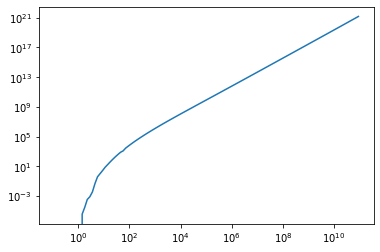

In [95]:
plt.xscale('log')
plt.yscale('log')
plt.plot(E, M[0,120:,0])

In [97]:
np.savetxt('Matrices/P_fast_p+_{}_{}m.csv'.format(atmice_labels[1], elev), M[0,:120], delimiter=',')
np.savetxt('Matrices/P_fast_n0_{}_{}m.csv'.format(atmice_labels[1], elev), M[0,120:], delimiter=',')
np.savetxt('Matrices/P_neg_p+_{}_{}m.csv'.format(atmice_labels[1], elev), M[1,:120], delimiter=',')
np.savetxt('Matrices/P_neg_n0_{}_{}m.csv'.format(atmice_labels[1], elev), M[1,120:], delimiter=',')

np.savetxt('Matrices/Depth.csv', z, delimiter=',')
np.savetxt('Matrices/Energy.csv', E, delimiter=',')

In [64]:
for i,ai in enumerate(atmice0):
    file = 'Matrices/P_rates_{}_{}m.npy'.format(atmice_labels[i], elev)
    print(file)
    if not os.path.isfile(file):
        Phi_ice = ai[0](Phi0, *ai[1])
        P_fast, P_neg = Dyonisius_both(np.array([Phi_ice]))
        Matrix = np.array([P_fast[0], P_neg[0]])[:,:,:,0]
        np.save(file, Matrix)

Matrices/P_rates__MCEq-SIBYLL-2.3c-CORSIKA_USStd_3120m.npy
Matrices/P_rates__MCEq-SIBYLL-2.3c-CORSIKA_SP_Dec_3120m.npy
Matrices/P_rates__MCEq-SIBYLL-2.3-CORSIKA_USStd_3120m.npy


  0%|                                                                                           | 0/10 [00:09<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
#Phi_atm, Phi_ice, P_14CO, CO = primary_to_14CO(Phi0)

In [ ]:
for c in CO:
    plt.plot(z[i_int], c[0])
#for c in CO[1]:
    #plt.plot(z[i_int], c)
plt.plot(hdus['DEPTH'].data, hdus['CO14'].data[68], ls='--', c='r')
plt.show()

In [ ]:
for p in P_14CO:
    plt.plot(z, p[0])
#for c in CO[1]:
    #plt.plot(z[i_int], c)
plt.yscale('log')
plt.show()

In [ ]:
for p in Phi_ice:
    plt.plot(z_bins, np.sum(p[0,:,:,:,0]*dE.reshape((1,-1,1)), axis=(0,1)))
#for c in CO[1]:
    #plt.plot(z[i_int], c)
plt.yscale('log')
plt.show()

In [ ]:
np.shape(Phi_atm)

In [ ]:
print(np.sum(Phi_atm[0,0,:,:,:,0]*np.reshape(dcosTH,(-1,1,1))*dE, axis=(0,1,2)))

In [ ]:
np.sum(Phi_ice[0,0,:,:,:,0]*np.reshape(dE,(1,-1,1)), axis=(0,1))

In [ ]:
phi_all(h_bins,np.append(dh,dh[-1]),H)[0]

In [ ]:
for p in Phi_atm:
    plt.plot(E, np.sum(p[0]*dcosTH, axis=(0,1,3)))
#for c in CO[1]:
    #plt.plot(z[i_int], c)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [ ]:
np.shape(Phi_atm)

In [ ]:
len(CO)

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5), tight_layout=True, sharex=True)

#ax1.plot(z[i_int], CO[0,0], label='Judge-Nash Atm Fit')
#ax2.plot(z[i_int], CO[0,0]/CO[-2,0])
#for i,c in enumerate(CO[1]):
    #ax1.plot(z[i_int], c, ls=':', label=p_names[i])
    #ax2.plot(z[i_int], c/CO[-2,0], ls=':')
for i,c in enumerate(CO):
    if i<len(CO)-3:
        ax1.plot(z[i_int], c[0], ls=':', label=model_names[i])
        ax2.plot(z[i_int], c[0]/CO[-2,0], ls=':')
for i,c in enumerate(CO[1]):
    ax1.plot(z[i_int], c, ls=':')
    ax2.plot(z[i_int], c/CO[-2,0], ls=':')
for i,c in enumerate(CO[3]):
    ax1.plot(z[i_int], c, ls=':')
    ax2.plot(z[i_int], c/CO[-2,0], ls=':')
ax1.plot(z[i_int], CO[-2,0], label='Balco Python')
ax2.plot(z[i_int], CO[-2,0]/CO[-2,0])
#ax1.plot(z[i_int], hdus['CO14'].data[68][1:], ls='--', c='r', label='Balco Matlab')
#ax2.plot(z[i_int], hdus['CO14'].data[68][1:]/CO[-2,0], ls='--', c='r')

ax1.set(#xlim=(z[i_int][0],z[i_int][-1]),
       xlabel='depth [m]',
       ylim=(0,30),
       ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
ax1.legend(loc='lower right', fontsize=8)

ax2.set(xlim=(z[i_int][0],z[i_int][-1]),
       xlabel='depth [m]',
       #ylim=(0.98,1.06),
       ylabel=r'$^{14}$CO ratio to Balco')
#ax2.legend(loc='best', fontsize=10)

plt.suptitle('In Situ 14CO Concentration over Depth')
plt.show()

In [ ]:
model_names[3]

In [ ]:
hdus['CO14'].data[68][1:]/CO[0,-1,0]